### Basing the model off of the MLP paper Bengio et al. 2003:

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

(P.S: The paper uses 17000 words and applies word embedding. Here, the data is 'names.txt' and we apply character embedding.)

In [33]:
# In the previous code (part 1), we imlemented 'bigram'. 
# Here in part 2, we are implementing 'mlp'. 

import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 

import random

In [34]:
# read in all the words: 
words = open("names.txt", 'r').read().splitlines()
print(words[0:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [35]:
# build the vocabulary of characters to/from integers 

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [36]:
# building the dataset: 

block_size = 3 # = context length = how many characters do we take to predict the next one? 
X, Y = [], [] 
for w in words: 
    
    # print(w)
    context = [0]*block_size # provide padding before the first character 
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context) 
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', ch) # ch = itos[ix]
        context = context[1:] + [ix] #update 'context' 
X = torch.tensor(X)
Y = torch.Tensor(Y)

In [37]:
print(X.shape, X.dtype, Y.shape, Y.dtype)
print(X)
print(Y)

torch.Size([228146, 3]) torch.int64 torch.Size([228146]) torch.float32
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])
tensor([ 5., 13., 13.,  ..., 26., 24.,  0.])


In [38]:
# Embedding matrix/look-up table (table for embedding the 27 alphabetical characters)

C = torch.randn((27, 2))
emb = C[X]

print(emb.shape)
print(emb[:2])

torch.Size([228146, 3, 2])
tensor([[[ 0.5422, -0.0506],
         [ 0.5422, -0.0506],
         [ 0.5422, -0.0506]],

        [[ 0.5422, -0.0506],
         [ 0.5422, -0.0506],
         [-0.3963,  0.3221]]])


In [39]:
# Constructing the first hidden layer: 

w1 = torch.randn((6, 100)) #6=emb.shape[1]*emb.shape[2]  #100 hidden neurons
b1 = torch.randn((100))

# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape 
#make it so that emb(32, 3, 2) would have shape (32, 6) so that we can multiply it by w1(6,100).
# which is the same as: 
# torch.cat(torch.unbind(emb, dim=1), dim=1).shape
# which is also the same as: 
# emb.view(); with view() being more efficinet memory wise! 
# link: https://blog.ezyang.com/2019/05/pytorch-internals/

h = torch.tanh(emb.view(-1, 6) @ w1 + b1) # -1: Pytorch figures it out itself. # the elemnets of 'h' are between (-1,1) because of tanh. 
# shape = (32, 100)

# constructing the second hidden layer: 
w2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ w2 + b2 # the outputs of teh neural net # shape = (32, 27)

# softmax: 
counts = logits.exp() 
prob = counts / counts.sum(1, keepdims=True) # shape = (32, 27)

In [40]:
Y

tensor([ 5., 13., 13.,  ..., 26., 24.,  0.])

In [41]:
# loss = -prob[torch.arange(32), Y.long()].log().mean() # long() because 
# print(loss)

## ---------------------Now making it more respectable: ---------------------

In [42]:
print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [43]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [44]:
sum(p.nelement() for p in parameters)

3481

In [45]:
for p in parameters: 
    p.requires_grad = True

In [46]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # spacing exponentially 

In [47]:
lri = [] 
lossi = []

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass:
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 100)
    logits = h @ w2 + b2 # (32, 27)
    # counts = logits.exp() # this line and the 2 below are basiclaly classification, so we can use crossentropy. 
    # prob = counts / counts.sum(1, keepdims=True) 
    # loss = -prob[torch.arange(32), Y.long()].log().mean()
    loss = F.cross_entropy(logits, Y[ix].long())
    # print(loss.item())
    
    # Backward pass:
    for p in parameters: 
        p.grad = None
    loss.backward()
    
    # Update parameters: 
    # lr = lrs[i]
    lr = 0.1
    for p in parameters: 
        p.data += -lr * p.grad

    # Track stats: 
    lri.append(lr) 
    lossi.append(loss.item())

# print(loss.item())
# plt.plot(lri, lossi)

## ---------------------Now using train/test/dev dataset: ---------------------

In [95]:
# training split, dev/validation split, test split: 80%, 10%, 10% 

# build the dataset: 

def build_dataset(words): 
    block_size = 3 # = context length = how many characters do we take to predict the next one? 
    X, Y = [], [] 
    for w in words: 
        
        # print(w)
        context = [0]*block_size # provide padding before the first character 
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) 
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', ch) # ch = itos[ix]
            context = context[1:] + [ix] #update 'context' 
    X = torch.tensor(X)
    Y = torch.Tensor(Y)
    print(X.shape, Y.shape) 
    return X, Y 

random.seed(42)
random.shuffle(words) 
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [96]:
print(Xtr.shape, Ytr.shape)

torch.Size([182512, 3]) torch.Size([182512])


In [97]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total 

for p in parameters: 
    p.requires_grad = True

11897


In [98]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # spacing exponentially 


lri = [] 
lossi = []
stepi = []
lossilog = []

In [117]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass:
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1) #(32, 100)
    logits = h @ w2 + b2 # (32, 27)
    # counts = logits.exp() # this line and the 2 below are basiclaly classification, so we can use crossentropy. 
    # prob = counts / counts.sum(1, keepdims=True) 
    # loss = -prob[torch.arange(32), Y.long()].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix].long())
    # print(loss.item())
    
    # Backward pass:
    for p in parameters: 
        p.grad = None
    loss.backward()
    
    # Update parameters: 
    # lr = lrs[i]
    lr = 0.01
    lr = 0.1 if i<100000 else 0.01 # dynamic learning rate :D
    for p in parameters: 
        p.data += -lr * p.grad

    # Track stats: 
    # lri.append(lr)  
    stepi.append(i)
    lossi.append(loss.item())
    lossilog.append(loss.log10().item())

# print(loss.item())
# plt.plot(lri, lossi)

In [118]:
print(loss.item())

2.211822271347046


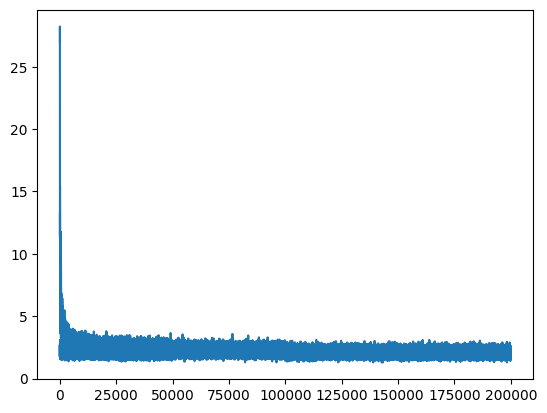

In [119]:
plt.plot(stepi, lossi)

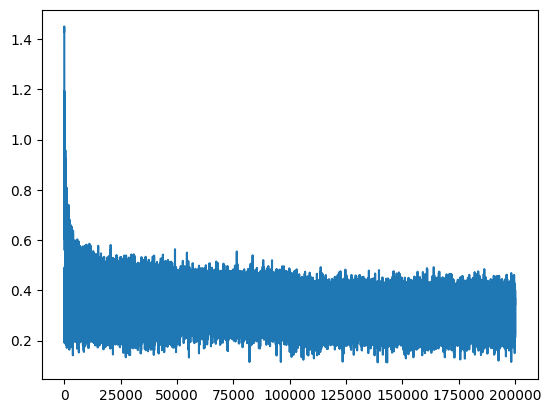

In [120]:
plt.plot(stepi, lossilog)

In [ ]:
# training loss:  

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) #(32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr.long())
print(loss.item())

In [121]:
# validation loss: 

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) #(32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev.long())
print(loss.item())

2.144472122192383


In [ ]:
# test loss: 

emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) #(32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte.long())
print(loss.item())

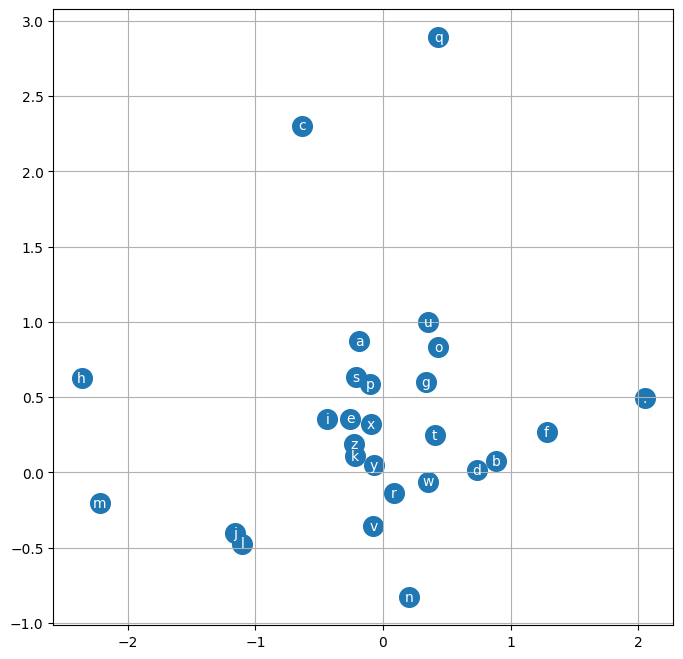

In [122]:
# visualiza dimensions 0 and 1 of the embedding matrix C for all characters

plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
plt.grid('minor')
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")

In [125]:
# sample from the dataset 

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20): 
    out = [] 
    context = [0] * block_size # initializa with all ... 
    while True: 
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2 
        probs = F.softmax(logits, dim=1)
        ix =  torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix) 
        if ix == 0: 
            break  
    print(''.join(itos[i] for i in out))

carmah.
quillivith.
miliataly.
skarsha.
jazhuen.
deliah.
jareen.
nellara.
chaiivia.
leigh.
ham.
jorn.
quinthonor.
malian.
quinterri.
jarynix.
kaeliigh.
brex.
edi.
abgan.
